THE CODE BELOW INTEGRATES THE HW4 STUFF AND ADDS THE WORK FROM ABOVE...

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings
import pickle
import os

warnings.filterwarnings('ignore')
path = 'inputs/'
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', 500)
pd.set_option('display.expand_frame_repr', False)

# Add holidays
def insert_holidays(testy, stores_new):
    data = testy.copy()
    data['nat_holiday'] = 0
    data['reg_holiday'] = 0
    data['loc_holiday'] = 0

    stores = stores_new.copy()
    holidays = pd.read_csv(path + 'holidays_events.csv',
                        usecols=['date', 'type', 'locale', 'locale_name', 'transferred'],
                        dtype={'type': 'category', 'locale': 'category', 'locale_name': 'category', 'transferred': 'bool'},
                        parse_dates=['date'], infer_datetime_format=True
                        )
    holidays = holidays.reset_index()
    stores = stores.reset_index()

    for index, row in holidays.iterrows():
        store_nbr_list = []
        if row['locale'] == 'Local':
            for sindex, srow in stores.iterrows():
                if srow['city'] == row['locale_name']:
                    data.loc[(data['date'] == row['date']) & (data['store_nbr'] == srow['store_nbr']), 'loc_holiday'] = 1
        if row['locale'] == 'Regional':
            for sindex, srow in stores.iterrows():
                if srow['state'] == row['locale_name']:
                    data.loc[(data['date'] == row['date']) & (data['store_nbr'] == srow['store_nbr']), 'reg_holiday'] = 1
        if row['locale'] == 'National':
            data.loc[data['date'] == row['date'], 'nat_holiday'] = 1

    return data


#Adapted from https://www.kaggle.com/code/enesdilsiz/time-series-forecasting-with-lightgbm
def random_noise(dataframe):
    x = np.random.normal(scale=1.5, size=(len(dataframe),))
    return x

# Data preprocessing functions
def lag_features(dataframe, lags, feature):
    for lag in lags:
        dataframe[str(feature) + '_lag_' + str(lag)] = dataframe.groupby(["store_nbr", "family"])[feature].transform(
            lambda x: x.shift(lag))
        #+ random_noise(dataframe)
    return dataframe

def roll_mean_features(dataframe, windows, feature):
    for window in windows:
        dataframe[str(feature) + '_roll_mean_' + str(window)] = dataframe.groupby(["store_nbr", "family"])[feature]. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe


def ewm_features(dataframe, alphas, lags, feature):
    for alpha in alphas:
        for lag in lags:
            dataframe[str(feature) + '_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store_nbr", "family"])[feature].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe


def lag_all_features(data, features):
    lags = [x for x in range(1,16)]
    alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
    windows = [128, 365, 546]
    for feature in features:
        data = lag_features(data, lags, feature)
        data = roll_mean_features(data, windows, feature)
        data = ewm_features(data, alphas, lags, feature)
    return data

# Loss Functions
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val


def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(preds, labels)
    return 'SMAPE', smape_val, False


def rmsle_lgbm(y_pred, data):
    y_true = np.array(data.get_label())
    score = np.sqrt(np.mean(np.power(np.log1p(y_true) - np.log1p(y_pred), 2)))
    return 'rmsle', score, False

# Plotting and post processing functions
def plot_lgb_importances(model, plot=False, num=10):
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show(block=True)
    else:
        print(feat_imp.head(num))
    return feat_imp

In [20]:

# Load Oil Data
data_oil = pd.read_csv(path + 'oil.csv', parse_dates=['date'], infer_datetime_format=True)
data_oil['dcoilwtico'].fillna(method='ffill', inplace=True)
data_oil['ma_oil'] = data_oil['dcoilwtico'].rolling(7).mean()
data_oil['ma_oil'].fillna(method='ffill', inplace=True)
calendar = pd.DataFrame()
calendar['date'] = pd.date_range('2013-01-01', '2017-08-31')
cally = pd.merge(calendar, data_oil, how='outer', on='date' )
cally.fillna(method='ffill', inplace=True)
calendar = cally.copy()    #1704 rows

# Load Stores
stores_new = pd.read_csv(path + 'stores.csv',
                         usecols=['store_nbr', 'city', 'state', 'type', 'cluster'],
                         dtype={'store_nbr': 'category', 'city': 'category', 'state': 'category', 'type': 'category', 'cluster': 'category'})

transactions = pd.read_csv(path + 'transactions.csv',
                          usecols=['store_nbr', 'date', 'transactions'],
                          dtype={'store_nbr': 'category', 'transactions': 'float32'},
                          parse_dates=['date'], infer_datetime_format=True)

df_train = pd.read_csv(path + 'train.csv',
                       usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
                       dtype={'store_nbr': 'category', 'family': 'category', 'sales': 'float32', 'onpromotion': 'float32'},
                       parse_dates=['date'], infer_datetime_format=True)

df_test = pd.read_csv(path + 'test.csv',
                       usecols=['store_nbr', 'family', 'date', 'onpromotion'],
                       dtype={'store_nbr': 'category', 'family': 'category', 'onpromotion': 'float32'},
                       parse_dates=['date'], infer_datetime_format=True)

df_test['sales'] = np.nan

df_train = pd.concat([df_train, df_test] )


train_oil = pd.merge(df_train, calendar, how='outer', on='date')
train_oil.sort_values(by=['family','store_nbr'], axis=0, inplace=True)
train_oil['ma_oil'].fillna(method='ffill', inplace=True)
train_oil['dcoilwtico'].fillna(method='ffill', inplace=True)
train_oil_trans = pd.merge(transactions, train_oil, how='outer', on =['store_nbr', 'date'])
# train_oil_trans = train_oil_trans[train_oil_trans['family'].notna()]
# tmp.sort_values(by=['store_nbr', 'sales'], axis=0, inplace=True)
# train_oil_trans[train_oil_trans['transactions'].isnull()]
train_oil_trans_stores = train_oil_trans.merge(stores_new, on='store_nbr')
train_oil_trans_stores_holiday = insert_holidays(train_oil_trans_stores, stores_new)
# tmp = train_oil_trans_stores_holiday[train_oil_trans_stores_holiday.transactions.isnull()]
# tmp = tmp.loc[(tmp.nat_holiday != 1) & (tmp.reg_holiday != 1) & (tmp.loc_holiday != 1)]
# tmp
train_oil_trans_stores_holiday.transactions.fillna(0, inplace=True)
data = train_oil_trans_stores_holiday.copy()
del train_oil_trans_stores_holiday, train_oil_trans_stores, train_oil_trans, train_oil, data_oil, df_train, transactions, cally
data.sort_values(by=['store_nbr', 'family', 'date'], axis=0, inplace=True)
feats = ['sales', 'ma_oil', 'dcoilwtico']
data = lag_all_features(data, feats)
# data.family.nunique()

In [22]:

df = data.copy()
df['year'] = df.date.dt.year
df['month'] = df.date.dt.month
df['quarter_of_year'] = df.date.dt.quarter
df['week_of_year'] = df.date.dt.isocalendar().week
df['day_of_year'] = df.date.dt.dayofyear
df['day_of_month'] = df.date.dt.day
# df['day_of_week'] = df.date.dt.dayofweek
df["is_wknd"] = df.date.dt.weekday // 4
df['is_month_start'] = df.date.dt.is_month_start.astype(int)
df['is_month_end'] = df.date.dt.is_month_end.astype(int)
 # pd.DataFrame({"sales": df["sales"].values[0:10],
 #              "lag1": df["sales"].shift(1).values[0:10],
 #              "lag2": df["sales"].shift(2).values[0:10],
 #              "lag3": df["sales"].shift(3).values[0:10],
 #              "lag4": df["sales"].shift(4).values[0:10]})

In [23]:
alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
df = data.copy()

In [24]:
# df = pd.get_dummies(df, columns=[ 'day_of_week', 'month'])

In [25]:
df = pd.get_dummies(df, columns=[ 'store_nbr', 'family', 'city', 'state'])

In [26]:
import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [27]:

train = df.loc[(df.date < "2013-07-31"), :]
val = df.loc[(df.date >= "2013-07-31" ) & (df.date < "2017-08-16")]

cols = [col for col in train.columns if col not in ['date', 'sales', 'transactions' ]]

Y_train = train['sales']
X_train = train[cols]

Y_val = val['sales']
X_val = val[cols]

Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((376002,), (376002, 412), (2624886,), (2624886, 412))

In [28]:
df.to_pickle('./engineeredFeatureDF.pkl')

In [29]:
def rlsme(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    preds[np.where(preds < 0)] = 0
    loss_val = np.sum(np.square((np.log(1+preds) - np.log(1 + target)))) / n
    return np.sqrt(loss_val)


def lgbm_rlsme(preds, train_data):
    labels = train_data.get_label()
    loss = rlsme(preds, labels)
    return "RMSLE", loss, False

In [30]:
lgb_params = {'num_leaves': 50,
              'learning_rate': 0.03,
              'feature_fraction': 0.8,
              'max_depth': 30,
              'verbose': 0,
              'num_boost_round': 20000,
              'early_stopping_rounds': 400,
              'nthread': -1}

trial_num = 'trial_11'
os.makedirs(f'models/{trial_num}', exist_ok=True)
pickle.dump(lgb_params, open(f"models/{trial_num}/params.dat", 'wb'))

In [31]:
lgbtrain_smape = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval_smape = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain_smape, feature_name=cols)

lgbtrain_rlsme = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval_rlsme = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain_rlsme, feature_name=cols)


LightGBM -- Setup

In [32]:
model_smape = lgb.train(lgb_params, lgbtrain_smape,
                  valid_sets=[lgbtrain_smape, lgbval_smape],
                  num_boost_round=lgb_params['num_boost_round'],
                #   callbacks=[lgb.early_stopping(stopping_rounds=200)],
                  feval=lgbm_smape,
                  verbose_eval=100)

pickle.dump(model_smape, open(f"models/{trial_num}/lgbm_smape_1.dat",'wb'))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.201528 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 400 rounds
[100]	training's l2: 15055.2	training's SMAPE: 123.448	valid_1's l2: 155595	valid_1's SMAPE: 107.105
[200]	training's l2: 10015.3	training's SMAPE: 116.89	valid_1's l2: 233424	valid_1's SMAPE: 104.416
[300]	training's l2: 8426.22	training's SMAPE: 118.103	valid_1's l2: 245029	valid_1's SMAPE: 104.204
[400]	training's l2: 7452.03	training's SMAPE: 118.474	valid_1's l2: 249891	valid_1's SMAPE: 104.438
Early stopping, best iteration is:
[67]	training's l2: 24662.4	training's SMAPE: 130.75	valid_1's l2: 135122	valid_1's SMAPE: 111.852


In [33]:
model_rlsme = lgb.train(lgb_params, lgbtrain_rlsme,
                  valid_sets=[lgbtrain_rlsme, lgbval_rlsme],
                  num_boost_round=lgb_params['num_boost_round'],
                #   callbacks=[lgb.early_stopping(stopping_rounds=200)],
                  feval=lgbm_rlsme,
                  verbose_eval=100)

pickle.dump(model_rlsme, open(f"models/{trial_num}/lgbm_rlsme_1.dat",'wb'))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.166175 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 400 rounds
[100]	training's l2: 15055.2	training's RMSLE: 1.92218	valid_1's l2: 155595	valid_1's RMSLE: 2.12388
[200]	training's l2: 10015.3	training's RMSLE: 0.910722	valid_1's l2: 233424	valid_1's RMSLE: 1.8026
[300]	training's l2: 8426.22	training's RMSLE: 0.663856	valid_1's l2: 245029	valid_1's RMSLE: 1.63648
[400]	training's l2: 7452.03	training's RMSLE: 0.622203	valid_1's l2: 249891	valid_1's RMSLE: 1.61879
Early stopping, best iteration is:
[67]	training's l2: 24662.4	training's RMSLE: 2.54871	valid_1's l2: 135122	valid_1's RMSLE: 2.41007


In [34]:
y_pred_val_smape = model_smape.predict(X_val, num_iteration=model_smape.best_iteration)
y_pred_val_rlsme = model_rlsme.predict(X_val, num_iteration=model_rlsme.best_iteration)

In [35]:
# smape(y_pred_val, Y_val)
smape(y_pred_val_smape, Y_val)

111.85170202974678

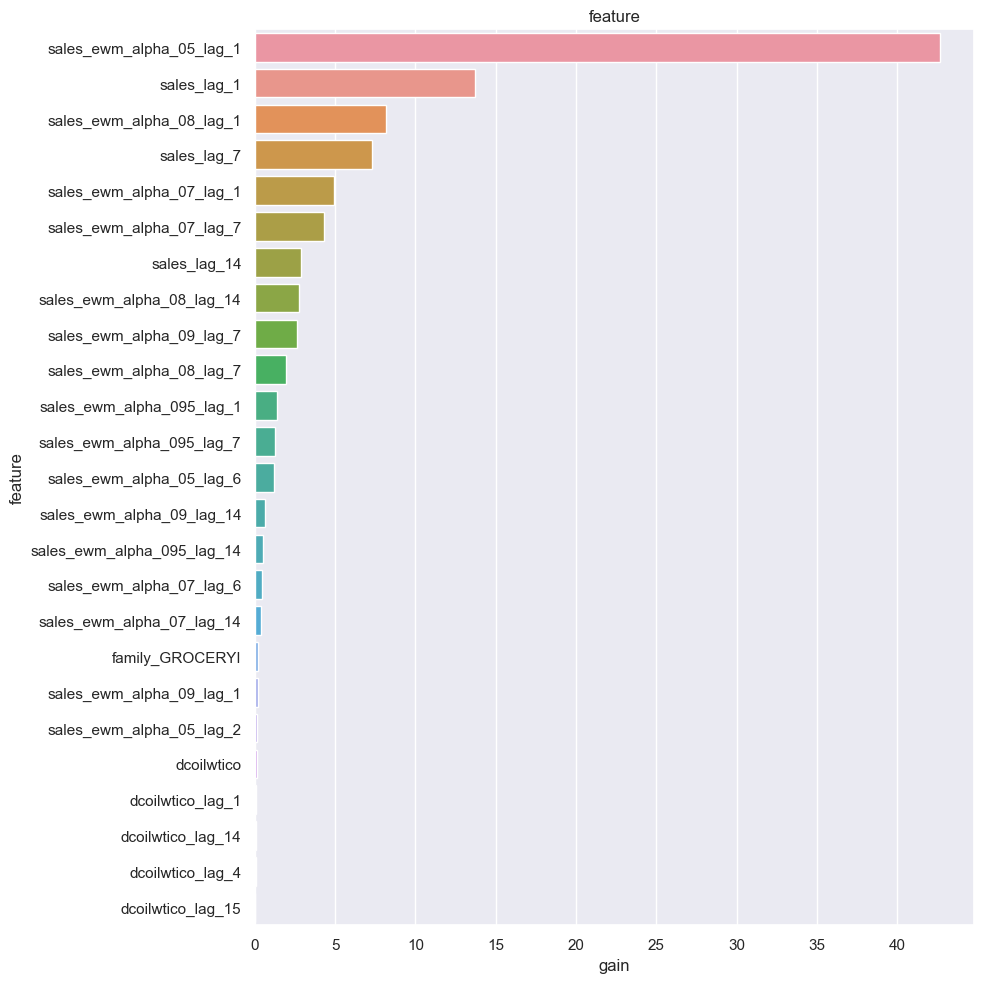

,feature,split,gain
86,sales_ewm_alpha_05_lag_1,162,42.642752
8,sales_lag_1,178,13.682378
56,sales_ewm_alpha_08_lag_1,43,8.166529
14,sales_lag_7,276,7.327075
71,sales_ewm_alpha_07_lag_1,59,4.952584
...,...,...,...
304,store_nbr_25,0,0.000000
305,store_nbr_26,0,0.000000
306,store_nbr_27,0,0.000000
307,store_nbr_28,0,0.000000


In [36]:
plot_lgb_importances(model_smape, num=30, plot=True)

In [37]:
rlsme(y_pred_val_rlsme, Y_val)

2.41007272496477

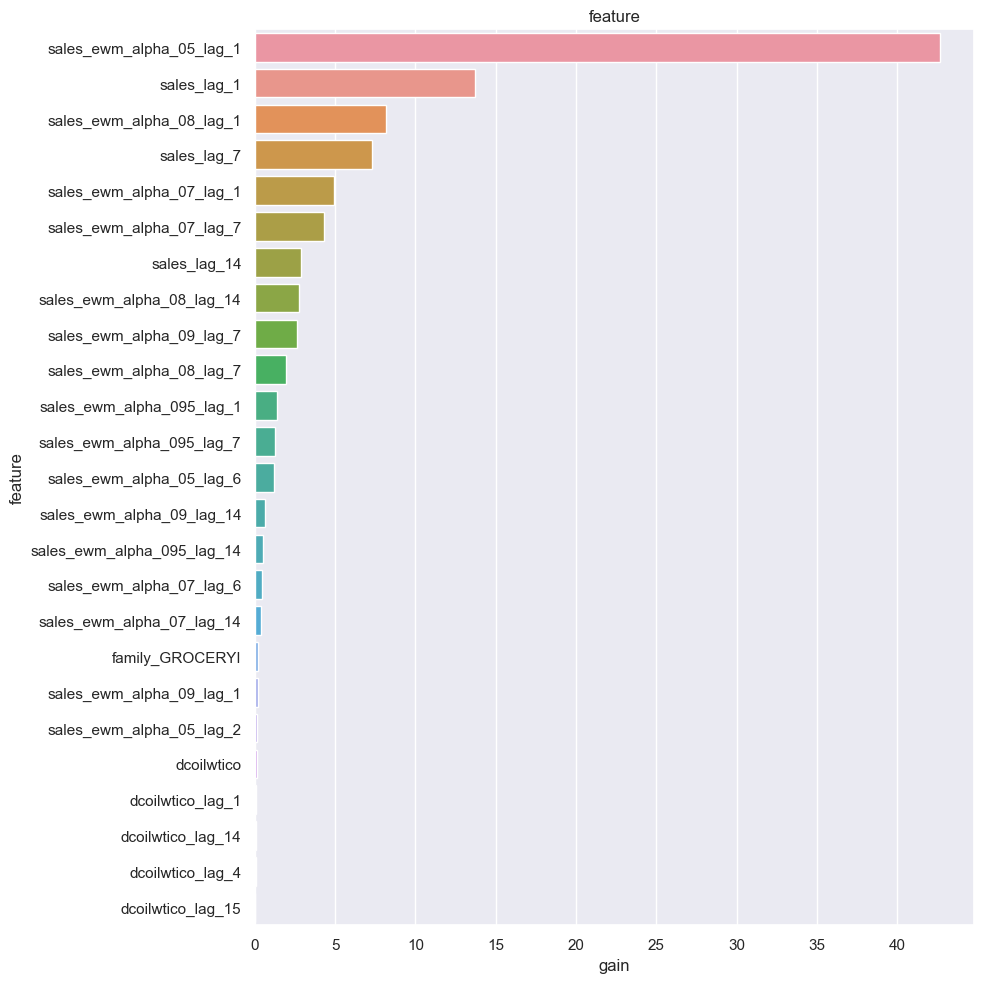

,feature,split,gain
86,sales_ewm_alpha_05_lag_1,162,42.642752
8,sales_lag_1,178,13.682378
56,sales_ewm_alpha_08_lag_1,43,8.166529
14,sales_lag_7,276,7.327075
71,sales_ewm_alpha_07_lag_1,59,4.952584
...,...,...,...
304,store_nbr_25,0,0.000000
305,store_nbr_26,0,0.000000
306,store_nbr_27,0,0.000000
307,store_nbr_28,0,0.000000


In [38]:
plot_lgb_importances(model_rlsme, num=30, plot=True)

In [39]:
feat_imp_rmsle = plot_lgb_importances(model_rlsme, num=200)

low_importance_rmsle = feat_imp_rmsle[feat_imp_rmsle["gain"] <= 0.005]["feature"].values

dff = df.drop(low_importance_rmsle, axis=1)

cols_dff = [col for col in dff.columns if col not in ['date', "sales", "year"]]

                            feature  split       gain
86         sales_ewm_alpha_05_lag_1    162  42.642752
8                       sales_lag_1    178  13.682378
56         sales_ewm_alpha_08_lag_1     43   8.166529
14                      sales_lag_7    276   7.327075
71         sales_ewm_alpha_07_lag_1     59   4.952584
..                              ...    ...        ...
271  dcoilwtico_ewm_alpha_07_lag_15      3   0.002097
153       ma_oil_ewm_alpha_08_lag_5      2   0.002091
162      ma_oil_ewm_alpha_08_lag_14      3   0.001987
256  dcoilwtico_ewm_alpha_08_lag_15      3   0.001932
173      ma_oil_ewm_alpha_07_lag_10      2   0.001925

[200 rows x 3 columns]


In [40]:
train = dff.loc[~df.sales.isna()]
Y_train = train['sales']
X_train = train[cols_dff]


test = dff.loc[df.date >= "2017-08-16"]
X_test = test[cols_dff]
# X_test.sales = np.nan

Y_train.shape, X_train.shape, X_test.shape

((3000888,), (3000888, 137), (28512, 137))

In [41]:
# lgb_params = {'num_leaves': 10,
#               'learning_rate': 0.02,
#               'feature_fraction': 0.8,
#               'max_depth': 5,
#               'verbose': 0,
#               'nthread': -1,
#               "num_boost_round": model_rlsme.best_iteration}
lgb_params["num_boost_round"] = model_rlsme.best_iteration
lgb_params["early_stopping_rounds"] = 0

In [42]:
lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols_dff)

In [43]:
final_model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model_rlsme.best_iteration)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.517198 seconds.
You can set `force_col_wise=true` to remove the overhead.


In [44]:
test_preds = final_model.predict(X_test, num_iteration=model_rlsme.best_iteration)

In [45]:
test_preds

array([51.82687237, 51.82687237, 52.55295707, ..., 63.55500648,
       64.33604952, 64.33604952])

In [46]:
test_preds[test_preds < 0] = 0

In [47]:
# Create submission
df_sub = pd.read_csv(path + 'sample_submission.csv', index_col='id')
df_sub.sales = test_preds
df_sub.to_csv('submission.csv', index=True)